In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
epoch_key = ('HPa', 6, 2)

In [4]:
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

In [5]:
from src.analysis import detect_epoch_ripples

ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
from src.analysis import (decode_ripple_clusterless, decode_ripple_sorted_spikes)

In [7]:
%%time

(ripple_info_sorted_spikes, decision_state_probability_sorted_spikes,
 posterior_density_sorted_spikes, state_names_sorted_spikes) = decode_ripple_sorted_spikes(
    epoch_key, ANIMALS, ripple_times, n_place_bins=61)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/links.py:478: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:124: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/projectnb/braincom/Jadhav-2016-Data-Analysis/src/ripple_decoding.py:563: UserWarning: Data is poorly scaled for neuron #7
  warn('Data is poorly scaled for neuron #{}'.format(ind + 1))


CPU times: user 18min 28s, sys: 3min 10s, total: 21min 39s
Wall time: 21min 40s


In [8]:
%%time

(ripple_info_clusterless, decision_state_probability_clusterless,
 posterior_density_clusterless, state_names_clusterless) = decode_ripple_clusterless(
     epoch_key, ANIMALS, ripple_times)

CPU times: user 3min 57s, sys: 10.3 s, total: 4min 8s
Wall time: 4min 8s


In [9]:
ripple_info_sorted_spikes

ripple_trajectory ripple_direction  \
animal day epoch ripple_number                                      
HPa    6   2     1                       inbound          reverse   
                 2                       inbound          reverse   
                 3                       inbound          reverse   
                 4                       inbound          reverse   
                 5                       inbound          reverse   
                 6                       inbound          forward   
                 7                       inbound          reverse   
                 8                       inbound          reverse   
                 9                       inbound          reverse   
                 10                      inbound          reverse   
                 11                      inbound          reverse   
                 12                     outbound          reverse   
                 13                     outbound          reverse   
                 14                     outbound          reverse   
                 15                      inbound          reverse   
                 16                     outbound          reverse   
                 17                     outbound          reverse   
                 18                      inbound          reverse   
                 19                      inbound          reverse   
                 20                      inbound          forward   
                 21                      inbound          reverse   
                 22                     outbound          reverse   
                 23                      inbound          reverse   
                 24                     outbound          reverse   
                 25                      inbound          reverse   
                 26                      inbound          reverse   
                 27                      inbound          reverse   
                 28                     outbound          forward   
                 29                      inbound          reverse   
                 30                     outbound          reverse   
...                                          ...              ...   
                 172                     inbound          forward   
                 173                     inbound          reverse   
                 174                    outbound          reverse   
                 175                     inbound          reverse   
                 176                     inbound          reverse   
                 177                     inbound          reverse   
                 178                     inbound          reverse   
                 179                     inbound          reverse   
                 180                     inbound          reverse   
                 181                     inbound          reverse   
                 182                    outbound          reverse   
                 183                     inbound          reverse   
                 184                     inbound          reverse   
                 185                     inbound          reverse   
                 186                     inbound          reverse   
                 187                    outbound          forward   
                 188                    outbound          forward   
                 189                     inbound          reverse   
                 190                     inbound          reverse   
                 191                     inbound          reverse   
                 192                     inbound          reverse   
                 193                     inbound          reverse   
                 194                     inbound          reverse   
                 195                     inbound          reverse   
                 196                     inbound          reverse   
                 197         

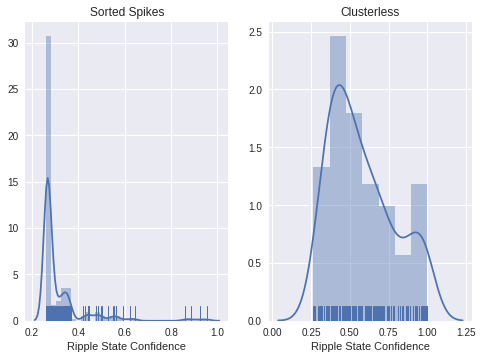

In [10]:
fig, ax = plt.subplots(1, 2)
sns.distplot(ripple_info_sorted_spikes.ripple_state_probability, rug=True, axlabel='Ripple State Confidence', ax=ax[0]);
ax[0].set_title('Sorted Spikes')

sns.distplot(ripple_info_clusterless.ripple_state_probability, rug=True, axlabel='Ripple State Confidence', ax=ax[1]);
ax[1].set_title('Clusterless');

In [11]:
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable

def browse_ripple_fits(decision_state_probability, state_names, sampling_frequency=1500):
    def plot_fits(ripple_ind):
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        lineObjects = plt.plot(time, decision_state_probability[ripple_ind])
        # plt.legend(lineObjects, discrete_state_names)
        for state_ind, state_name in enumerate(state_names):
                plt.text(time[-1] + (1 / sampling_frequency),
                         decision_state_probability[ripple_ind][-1, state_ind],
                         state_name,
                         color=lineObjects[state_ind].get_color())
        plt.ylim((0, 1))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability')
        plt.title('Ripple #{ripple_number}'.format(ripple_number=ripple_ind+1))
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)

def browse_ripple_densities(posterior_density, state_names,
                            place_bin_centers, sampling_frequency=1500):    
    def plot_fits(ripple_ind):
        fig, axes = plt.subplots(2, 2, figsize=(12,9), sharex=True, sharey=True)
        time_length = posterior_density[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        n_time = posterior_density[ripple_ind].shape[0]
        n_states = len(state_names)
        new_shape = (n_time, n_states, -1)
        cur_density = np.reshape(posterior_density[ripple_ind], new_shape)
        [time_grid, place_bins] = np.meshgrid(time, place_bin_centers)
        for state_ind, ax in enumerate(axes.flatten()):
            try:
                mesh = ax.pcolormesh(time_grid, place_bins, cur_density[:, state_ind, :].squeeze().T,
                                     cmap='PuRd', vmin=0, vmax=.1)
                ax.set_xlim((time.min(), time.max()))
                ax.set_ylim((place_bin_centers.min(), place_bin_centers.max()))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="2%", pad=0.05)
                plt.colorbar(mesh, cax=cax)
                ax.set_title(state_names[state_ind])
            except ValueError:
                pass
        fig.text(0.5, 0.04, 'Time (seconds)', ha='center')
        fig.text(0.04, 0.5, 'Linear Distance', va='center', rotation='vertical')
        
    interact(plot_fits, ripple_ind=(0, len(posterior_density)-1), continuous_update=False)

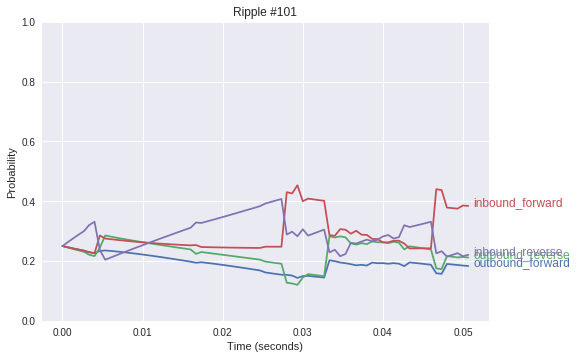

In [12]:
browse_ripple_fits(decision_state_probability_clusterless, state_names_clusterless)

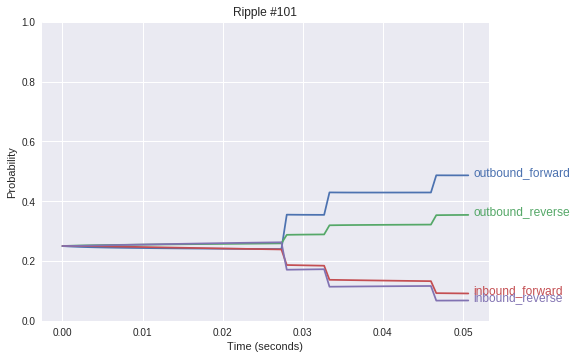

In [13]:
browse_ripple_fits(decision_state_probability_sorted_spikes, state_names_sorted_spikes)

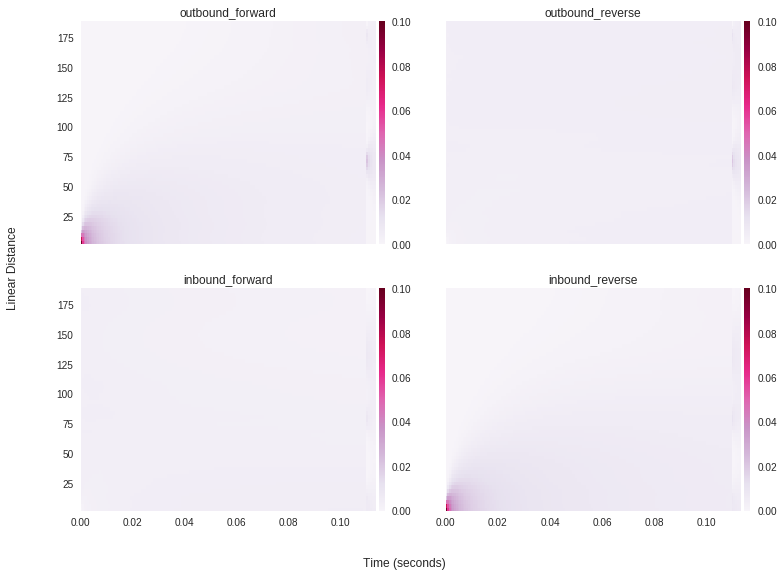

In [14]:
from src.ripple_decoding import get_bin_centers
from src.data_processing import get_interpolated_position_dataframe

n_place_bins = 61
position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
place_bin_edges = np.linspace(
    np.floor(position_info.linear_distance.min()),
    np.ceil(position_info.linear_distance.max()),
    n_place_bins + 1)
place_bin_centers = get_bin_centers(
    place_bin_edges)

browse_ripple_densities(posterior_density_sorted_spikes, state_names_sorted_spikes,
                        place_bin_centers)

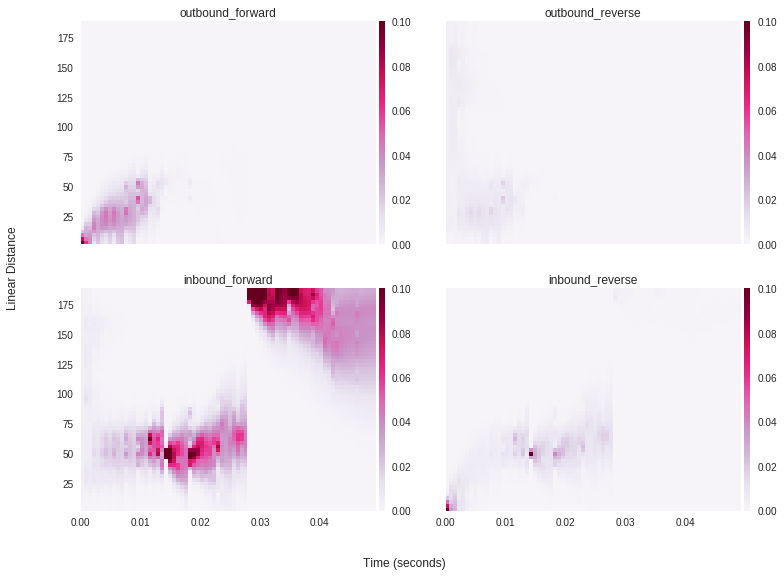

In [16]:
browse_ripple_densities(posterior_density_clusterless, state_names_clusterless,
                        place_bin_centers)